In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

In [2]:
def PrincetonDee(R1, R2):
    R0 = np.sqrt(R1 * R2)

    r = np.linspace(R2*0.9999, R1*1.0001, 500)
    integrand = np.log(r/R0)/np.sqrt(np.log(r/R1) * np.log(R2/r))
    z = cumulative_trapezoid(integrand, x=r, initial=0)

    r = np.concatenate([r, r[::-1]])
    z = np.concatenate([-z, z[::-1]])

    return r, z

In [3]:
import freegs
from freegs.machine import MirroredCoil, Solenoid, Wall

def compute_max_current(PR1, PZ1, PR2, PZ2):
    poloidal_coils = [
        ('PF1', MirroredCoil(PR1, PZ1)),
        ('PF2', MirroredCoil(PR2, PZ2))
    ]


    solenoid_height = 0.94
    inner_radius = 51e-3
    outer_radius = 60e-3
    solenoid_turns = 104
    central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2, solenoid_height / 2,
                                         solenoid_turns, control=False))]
    R0 = 0.28  # Middle of the circle
    rwall = 0.12  # Radius of the circular wall
    
    npoints = 200  # Number of points on the wall
    
    # Poloidal angles
    thetas = np.linspace(0, 2 * np.pi, npoints, endpoint=False)
    
    # Points on the wall
    Rwalls = R0 + rwall * np.cos(thetas)
    Zwalls = rwall * np.sin(thetas)
    
    walls = Wall(
        Rwalls,
        Zwalls
    )
    tokamak = freegs.machine.Machine(
        central_solenoid + poloidal_coils,
        walls
    )
    tokamak['PF1']['U'].area = tokamak['PF1']['L'].area = tokamak['PF2']['U'].area = tokamak['PF2'][
        'L'].area = 0.000213825 * 4
    eq = freegs.Equilibrium(tokamak=tokamak,
                            Rmin=0.01, Rmax=0.6,  # Radial domain
                            Zmin=-0.5, Zmax=0.5,  # Height range
                            nx=65, ny=65  # Number of grid points
                            )
    plasma_major_radius = 0.28
    toroidal_magnetic_field_strength_at_plasma_centre = 0.875
    vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre
    profiles = freegs.jtor.ConstrainBetapIp(eq,
                                            0.05,  # Plasma poloidal beta
                                            3e3,  # Plasma current [Amps]
                                            vacuum_toroidal_magnetic_field)  # Vacuum f=R*Bt
    xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points
    isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs
    constrain = freegs.control.constrain(isoflux=isoflux, xpoints=xpoints)
    xpoints = [(0.28, -0.24), (0.28, 0.24)]  # (R,Z) locations of X-points
    constrain = freegs.control.constrain(xpoints=xpoints)
    freegs.solve(eq,
                 profiles,
                 constrain,
                 show=False,
                 check_limited=False,
                 limit_it=0
                 )
    d = eq.tokamak.getCurrents()
    eq.tokamak.printCurrents()
    total_current = 0
    for _, v in d.items():
        total_current += abs(v)
    return total_current

In [4]:
def print_coil_positioning(PR1, PZ1, PR2, PZ2):
    r, z = PrincetonDee(0.1, 0.59)
    plt.figure(figsize=(5,7))
    plt.plot(r, z)
    plt.xlabel(r'$r$')
    plt.ylabel(r'$z$')

    r, z = PrincetonDee(0.1, 0.59 + 0.06)
    plt.plot(r, z)
    
    plt.plot(PR1, PZ1, label='P1', marker='x')
    plt.plot(PR2, PZ2, label='P2', marker='x')
    plt.plot(PR1, -PZ1, label='P1', marker='x')
    plt.plot(PR2, -PZ2, label='P2', marker='x')

    plt.show()

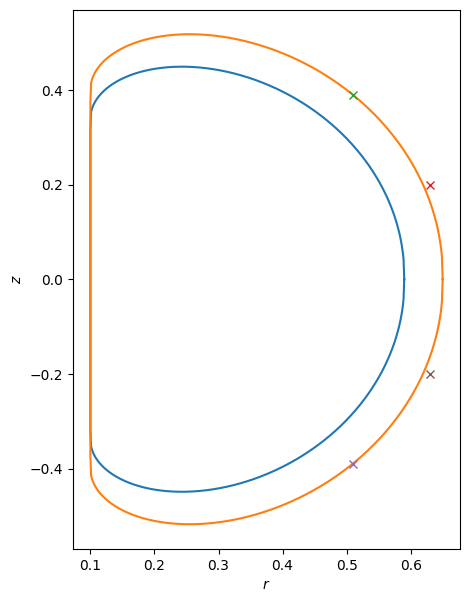

/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/jtor.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  shapeintegral, _ = quad(


RuntimeError: Picard iteration failed to converge (too many iterations)

In [5]:
PR1 = 0.51
PZ1 = 0.39
PR2 = 0.63
PZ2 = 0.20
print_coil_positioning(PR1, PZ1, PR2, PZ2)
compute_max_current(PR1, PZ1, PR2, PZ2)

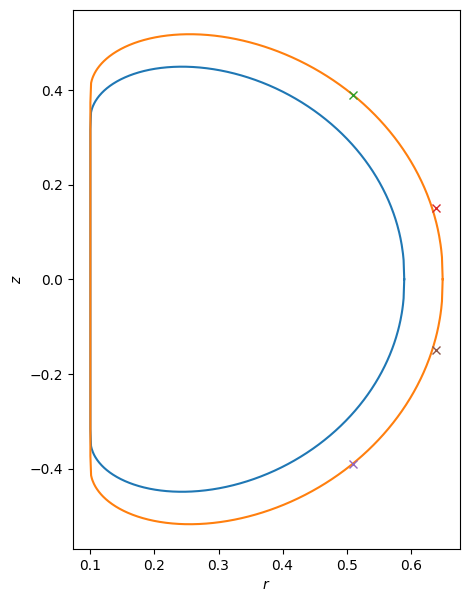

RuntimeError: Picard iteration failed to converge (too many iterations)

In [10]:
PR1 = 0.51
PZ1 = 0.39
PR2 = 0.63 + 0.01
PZ2 = 0.2 - 0.05
print_coil_positioning(PR1, PZ1, PR2, PZ2)
compute_max_current(PR1, PZ1, PR2, PZ2)

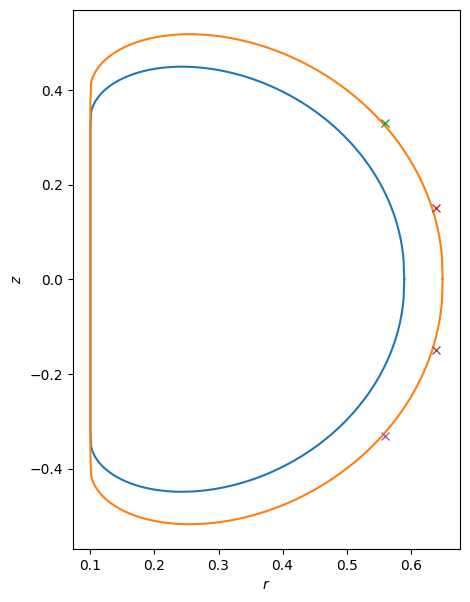

RuntimeError: Picard iteration failed to converge (too many iterations)

In [19]:
PR1 = 0.51 + 0.05
PZ1 = 0.39 - .06
PR2 = 0.64
PZ2 = 0.15
print_coil_positioning(PR1, PZ1, PR2, PZ2)
compute_max_current(PR1, PZ1, PR2, PZ2)